In [57]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [43]:
import numpy as np
import pandas as pd

In [44]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [45]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [46]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [47]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [48]:
# We can view all of the classes that automap found
Base.classes.keys()

[&#39;measurement&#39;, &#39;station&#39;]

In [49]:
# find all tables in DB
inspector = inspect(engine)
inspector.get_table_names()

[&#39;measurement&#39;, &#39;station&#39;]

In [50]:
# Save references to each table
Measurement = Base.classes.measurement
Station =  Base.classes.station

In [51]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [52]:
#Return the column names in Measurement table 
m_columns = inspector.get_columns('measurement')
for column in m_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [53]:
#Return the column names in Measurement table 
sta_columns = inspector.get_columns('station')
for column in sta_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [59]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#Find last Date in table 
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date[0], "%Y-%m-%d")
# Calculate the date 1 year ago from the last data point in the database

first_date = dt.date(2017,8,23) - dt.timedelta(days=365)

print(last_date)
print(first_date)
# Perform a query to retrieve the data and precipitation scores
last_365 = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= first_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_365_df=pd.DataFrame(last_365, columns=['Pdate','prcp'])
# Sort the dataframe by date
last_365_df = last_365_df.sort_values(["Pdate"])
last_365_df.set_index("Pdate", inplace=True)
last_365_df.head(5)


2017-08-23 00:00:00
2016-08-23


,prcp
Pdate,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


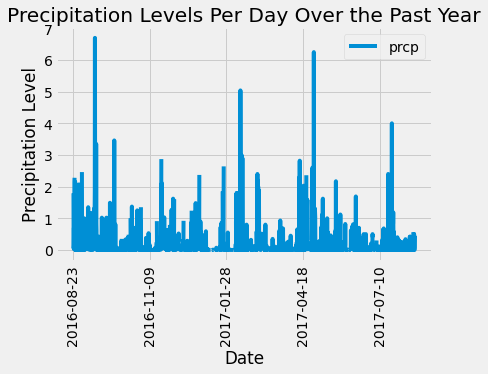

In [69]:
last_365_df.plot(rot=90)
plt.title("Precipitation Levels Per Day Over the Past Year")
plt.ylabel("Precipitation Level")
plt.xlabel("Date")
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_365_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [30]:
# Design a query to show how many stations are available in this dataset?
num_stations= session.query(Station.station).count()
print (num_stations)


9


In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(Station.station, func.count(Station.id)).\
    filter(Station.station == Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()

[(&#39;USC00519281&#39;, 2772),
 (&#39;USC00519397&#39;, 2724),
 (&#39;USC00513117&#39;, 2709),
 (&#39;USC00519523&#39;, 2669),
 (&#39;USC00516128&#39;, 2612),
 (&#39;USC00514830&#39;, 2202),
 (&#39;USC00511918&#39;, 1979),
 (&#39;USC00517948&#39;, 1372),
 (&#39;USC00518838&#39;, 511)]

In [33]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(Measurement.station, func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
    filter (Measurement.station == 'USC00519281').all()    

[(&#39;USC00519281&#39;, 54.0, 85.0, 71.66378066378067)]

In [77]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and 
USC00519281_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == 'USC00519281').\
                    filter(Measurement.date <= last_date).\
                    filter(Measurement.date >= first_date).\
                    all()
USC00519281_data[:5]

[(&#39;2016-08-23&#39;, 77.0),
 (&#39;2016-08-24&#39;, 77.0),
 (&#39;2016-08-25&#39;, 80.0),
 (&#39;2016-08-26&#39;, 80.0),
 (&#39;2016-08-27&#39;, 75.0)]

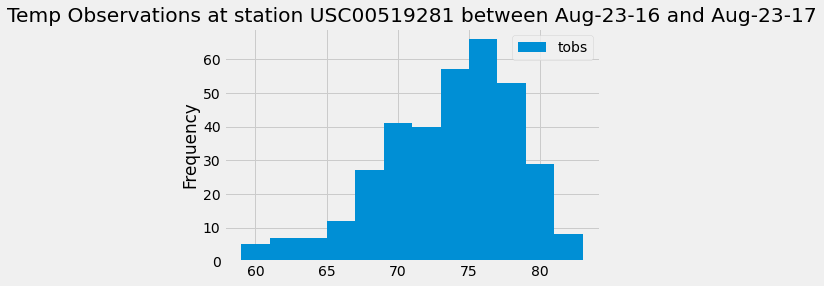

In [85]:
#plot the results as a histogram
USC00519281_df= pd.DataFrame(USC00519281_data)
USC00519281_df.plot(kind="hist", bins=12);
plt.title("Temp Observations at station USC00519281 between Aug-23-16 and Aug-23-17");


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
